# gridtools demo
Patrick Weygoldt, 2022/06/30, 08:09

Welcome to this demo of the gridtools module. It contains basic classes that utilize the wavetracker output to load, process and save electrode grid data. Lets begin by importing its contents. To run this code, a directory containing the following wavetracker output files is required:

- `times.npy`: 1d arrazy, the shared time vector
- `fund_v.np`: 1d array, all fundamental frequency tracks
- `sign_v.npy`: 2d array, powers for the fundamental frequencies across n electrodes
- `spec.npy`: 2d array, values for the coarse spectrogram
- `ident_v.py`: 1d array, track ids to connect the index vector to the time vector
- `idx_v.np`: 1d array, indices for the time vector

In my case, this data is stored in `../efishdata-local/2016-04-09-22_25`

DISCLAIMER before we start: The 'GridTracks' is also able to recompute the powers in the signature vector 'sign_v.npy' after frequency tracks were manually changed in the 'EODsorter.py' GUI application available in the wavetracker. However, this required a raw grid file present in the data directory, which is only present on the server for size reasons. Thus I will skip demonstrating this step.

In [30]:
from gridtools import GridTracks, Monad, Dyad, Collective
import matplotlib.pyplot as plt

## GridTracks

All classes in the gridtools module build on top of the `GridTracks` class and get `GridTracks` class instances as their arguments. Lets start by initiating a `GridTracks`class instance. By setting `finespec`to false we can omit loading the fine spectrogram.

In [31]:
path = "../efishdata-local/2016-04-09-22_25/"
grid = GridTracks(path, finespec = False, verbose = True)

[ GridTracks.__init__ ] No position estimations found in directory ../efishdata-local/2016-04-09-22_25/
[ GridTracks.__init__ ] No smoothed position estimations found in directory ../efishdata-local/2016-04-09-22_25/


The output should now tell us, what the class was able to load and what is not currently accessible in the directory. In this case, no position estimations where found. First, we'll take a look at the dataset.

[ GridTracks.plot_frequencies ]  Plotting frequency tracks ...


<AxesSubplot:>

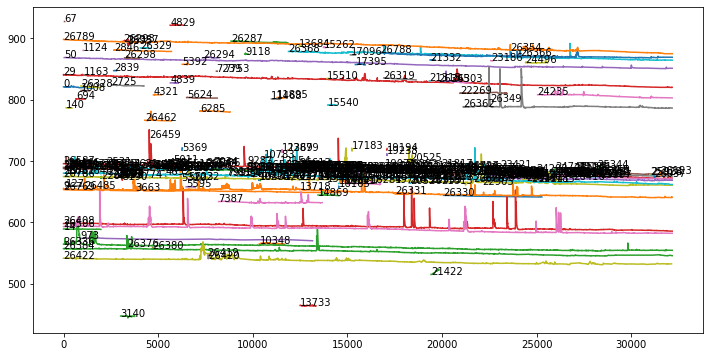

In [32]:
fig, ax = plt.subplots(figsize=(12,6))
grid.plot_freq(ax)

As you can see, the dataset is very cluttered and we only want to keep what is interesting for the analysis, i.e. long, good tracks. In the following, I'll demonstrate how to clean up the data and plot the frequency and position tracks of the grid recording. First, we can clean up the dataset by removing all NANs, removing very short tracks and removing all tracks where only limited datapoints were found:

In [33]:
grid.remove_nans() # to remove unassigned frequencies
grid.remove_short(1800) # to remove tracks shorter than 30 mins (=1800s)
grid.remove_poor(0.7) # to remove tracks below a tracking performance threshold of 70%

[ GridTracks.remove_nans ] Removed unassignes frequencies
[ GridTracks.remove_short ] No position data found.
[ GridTracks.remove_short ] Removed 363 short tracks with threshold of 1800 seconds.
[ GridTracks.remove_poor ] Removed 16 tracks with performance threshold 0.7


To check if this looks better now, let's just plot it again.

[ GridTracks.plot_frequencies ]  Plotting frequency tracks ...


<AxesSubplot:>

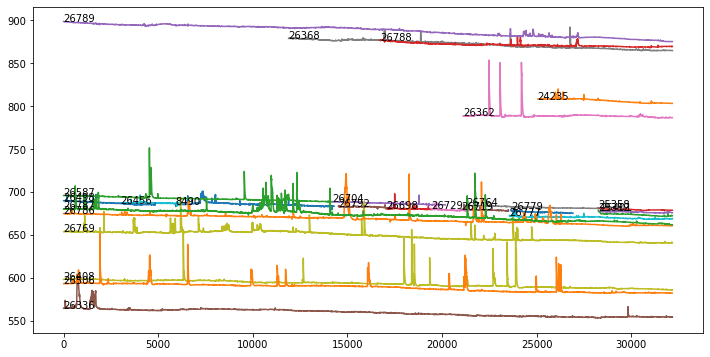

In [34]:
fig, ax = plt.subplots(figsize=(12,6))
grid.plot_freq(ax)

Now the dataset is ready for position estimation based on a set number of electrodes. Positions are estimated using the mean power of n electrodes weighted by their respective power. After position estimation, we can plot the positions on the grid to check if they look as they should. For this we have to tell the plotting function to plot the unsmoothed positions since we did not smooth them yet. You can play around with the number of electrodes to estimate positions. You'll see that as electrode number increases, position tracks become smoother but edge effects increase. This is because positions close to the edge of the grid can not be computed properly since there are no electrodes ouside the grid to weight the electrode means correctly. As a result, the more electrodes are used, the closer the edge positions will be pulled into the center of the grid. If will use 5 electrodes for now.

[ GridTracks.positions ] Computing fish positions from 5 electrodes ...
[ GridTracks.plot_pos ]  Plotting positions ...


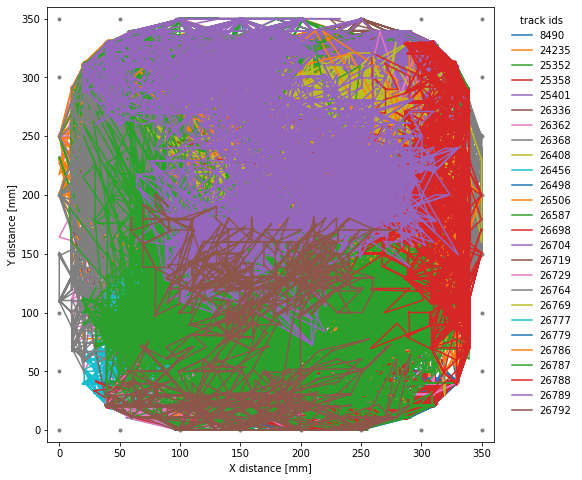

In [35]:
grid.positions(5) # calculate positions

fig, ax = plt.subplots(figsize=(8,8))
grid.plot_pos(ax, smoothed=False)

The positions are interpolated from subset of the 64 electrodes with the highest powers. But at this point, there are still gaps in the data. The fundamental frequencies of the fish are not the same lenths as the time array is. The same is true for the signature vector and the positions. Now is a good time to interpolate the data because now, we interpolate the seperate data dypes (frequencies, powers, positions) instead of computing the position data based on interpolated powers. Interpolation is easy:

In [36]:
grid.interpolate()

[ GridTracks.interpolate ] Interpolating fund_v, sign_v, xpos, ypos...


The position estimates still look very jumpy and have sharp edges so lets smooth them. For smoothing, I implemented a Savitzky-Golay filter that smoothes by computing an order k polynomial across n datapoints. I will use a polynomial of order 3 across 30 datapoints. Afterwards I plot the data to see the difference.

[ GridTracks.smooth_positions ]  Smoothing position tracks ...
[ GridTracks.plot_pos ]  Plotting positions ...


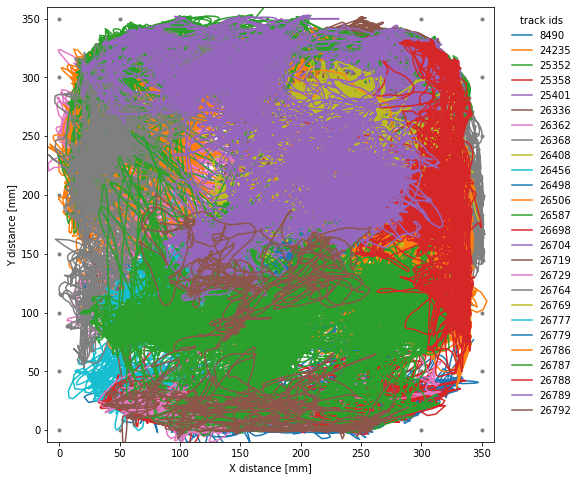

In [37]:
grid.smooth_positions(30, 3)

fig, ax = plt.subplots(figsize=(8,8))
grid.plot_pos(ax, smoothed=True)

This is a nice graph but because of the huge number of tracked fish, it does not show us where fish spent most of their time. For this we can compute a 2D histogram of fish positions. The function for this is implemented in the supplementary `functions` module.

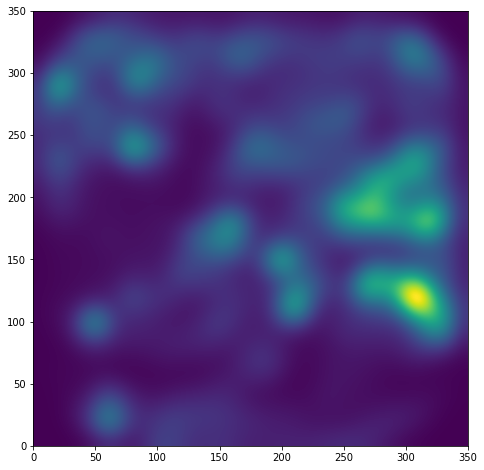

In [38]:
from functions import gaussianhist2d

heatmap = gaussianhist2d(grid.xpos_smth, grid.ypos_smth, extent=[(0,350),(0,350)], sigma = 32, bins = 1000)

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(heatmap, extent = [0,350,0,350])

Let's get back to the frequencies: Assume we are interested only in slow modulations but not in fast modulations or the other way around. For this, the tracks can be bandpass filtered to the timescale of interest. If `eod_shift` is enabled, the filtered traces are shifted back to the mode of their own frequency distribution.

[ GridTracks.freq_bandpass ] Applying bandpass filter ...
[ GridTracks.plot_frequencies ]  Plotting frequency tracks ...


<AxesSubplot:>

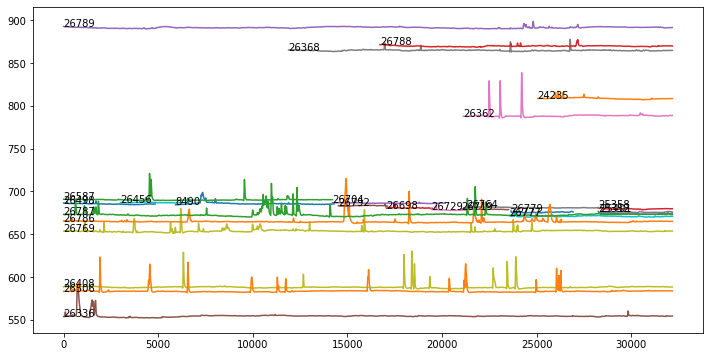

In [50]:
import copy

# make a copy
grid_bp = copy.deepcopy(grid)

# filter
grid_bp.freq_bandpass(rate = 3, flow = 0.00005, fhigh = 0.02, eod_shift = True)

# plot
fig, ax = plt.subplots(figsize = (12,6))
grid_bp.plot_freq(ax)


## Monad

A monad is a single isolated individual. Let's say you are specifically interested in a certain fish track because it has some cool frequency modulation. I'll choose individual 26362 because of its three consecutive large rises. To get this individual with all of its associated data from the grid dataset, we can simpy initiate a `Monad` instance.

Text(0, 0.5, 'y [cm]')

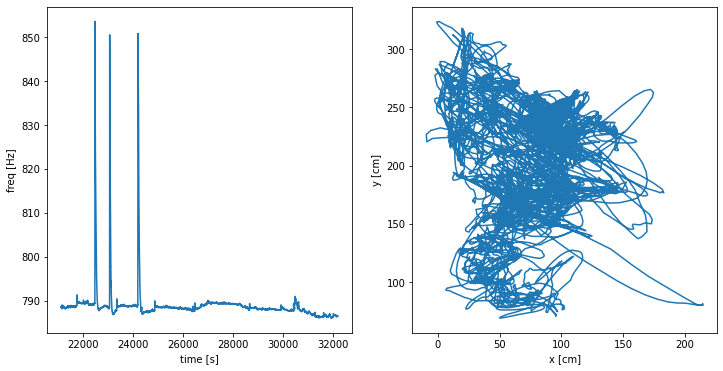

In [51]:
monad = Monad(grid, 26362)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(monad.times, monad.fund, label = monad.id)
ax1.set_xlabel('time [s]')
ax1.set_ylabel('freq [Hz]')
ax2.plot(monad.xpos_smth, monad.ypos_smth, label = monad.id)
ax2.set_xlabel('x [cm]')
ax2.set_ylabel('y [cm]')

To take it a bit further, lets look at where the fish was during its large rises. For that we can import a peak detection library and simpy look at the positions during the peaks.

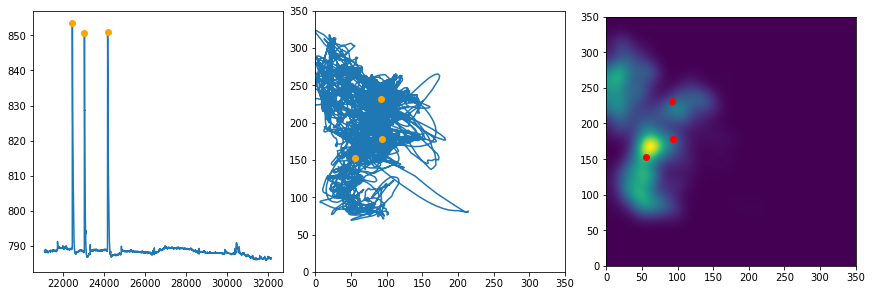

In [52]:
from scipy.signal import find_peaks

peaks = find_peaks(monad.fund, prominence=50)[0] # peak detection

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4), constrained_layout=True)

# plot frequencies
ax1.plot(monad.times, monad.fund)
ax1.scatter(monad.times[peaks], monad.fund[peaks], color = 'orange', zorder = 10)

# plot positions
ax2.plot(monad.xpos_smth, monad.ypos_smth)
ax2.scatter(monad.xpos_smth[peaks], monad.ypos_smth[peaks], color = 'orange', zorder = 10)
ax2.set_xlim(0,350)
ax2.set_ylim(0,350)

# plot fish 2d hist approx. during rise time window
pad = 2000
hist = gaussianhist2d(
    monad.xpos_smth[peaks[0]-pad:peaks[-1]+pad], 
    monad.ypos_smth[peaks[0]-pad:peaks[-1]+pad], 
    extent=[(0,350),(0,350)], 
    sigma = 32, 
    bins = 1000
)
ax3.imshow(hist, extent=[0,350,0,350])
ax3.scatter(monad.xpos_smth[peaks], monad.ypos_smth[peaks], color = 'red', zorder = 10)

Now we know not only when the fish produced rises but also where he was when rises where produced. This analysis could be extended much further, but what if we want to analyze what two fish did simultaneously?

## Dyad

The dyad class is probably the most interesting one because it can easily compute some interesting information about the interaction of two individuals. Let's say we are interested in individuals 26789 and 26788 (two males) because they modulate their frequency in synchrony at one point. Lets make a dyad out of them. The dyad class works the same as the monad class, just that we have two of each arrays except for a shared time array. Additionally, the dyad class comes with a spatial distance array `dpos` and a frequency difference array `dfund`. Lets plot the frequency, differece frequency and distance. In addition we can use peak detection again to look at where the fish were, when they came closest in frequency.

Text(0.5, 1.0, 'position differences')

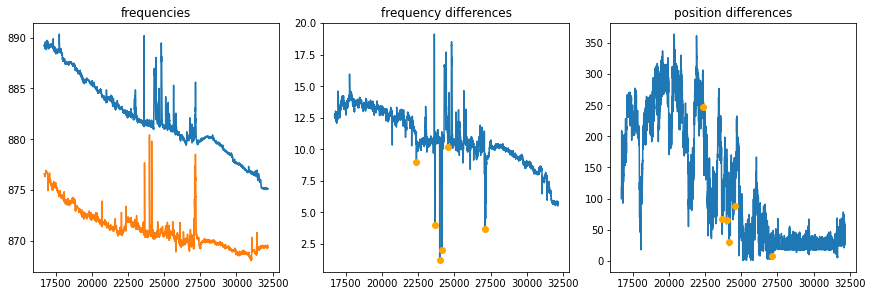

In [53]:
dyad = Dyad(grid, [26789, 26788])

# peak detection
peaks = find_peaks(-dyad.dfund, prominence=7)[0]

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4), constrained_layout=True)

ax1.plot(dyad.times, dyad.fund_id1, label = dyad.id1)
ax1.plot(dyad.times, dyad.fund_id2, label = dyad.id2)

ax2.plot(dyad.times, dyad.dfund)
ax2.scatter(dyad.times[peaks], dyad.dfund[peaks], color = 'orange', zorder = 10)
ax3.plot(dyad.times, dyad.dpos)
ax3.scatter(dyad.times[peaks], dyad.dpos[peaks], color = 'orange', zorder = 10)
ax1.set_title('frequencies')
ax2.set_title('frequency differences')
ax3.set_title('position differences')

As you can see, fish distance was below one meter for most rises and event dropped to 0 during the long, synchronous modulation at the end. Distances then stayed similar because fish entered the inactive phase.

## Collective

Two fish are cool but n fish are cooler. The `Collective` class utilizes monads and enables initiaton of an object with n fish tracks **if they share a common overlap**. Individual fish are then `Monad` instances inside the `Collective.monads` list and can be accessed by indexing the list. The respective ids are stored in the `Collective.ids` list. Lets initiate a collective of 3 individuals containing the two from above and fish 26368 (another male) that produced a rise during the frequency modulations of the other two.

(0.0, 350.0)

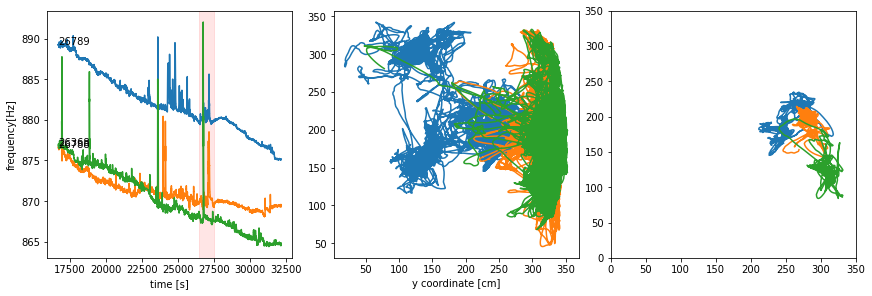

In [54]:
col = Collective(grid, [26789, 26788, 26368], thresh = 1)

import numpy as np
from functions import find_closest

# plot the data
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4), constrained_layout = True)
col.plot_freq(ax1)
col.plot_pos(ax2, legend=False)

# check out where they were during interaction
index = np.arange(len(col.monads[0].times))
start = index[find_closest(col.monads[0].times,26500)]
stop = index[find_closest(col.monads[0].times, 27500)]
ax1.axvspan(col.monads[0].times[start], col.monads[0].times[stop], color = 'red', alpha = 0.1)

for monad in col.monads:
    ax3.plot(monad.xpos_smth[start:stop], monad.ypos_smth[start:stop])
ax3.set_xlim(0,350)
ax3.set_ylim(0,350)

From this we see that the fish were not only close in frequency during interaction but also spatially.